# Topology optimization of a 3D heat sink
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/optimization/solid/topology_thermal_static.ipynb)


The model is defined on the cube $\Omega$ with length $L=1\,\text{m}$. An homogenous heat source is applied to the solution domain.
Simple isotropic Fourier's law connects diffusive heat flux $\boldsymbol{h}$ and temperature gradient via the scalar conductivity $\kappa=400\,\mathrm{W}/\mathrm{m\,K}$.

A constant Dirichlet temperature BC $T_D= 0\,\mathrm{K}$ is prescribed on portion on the bottom face.
Homogenous Neumann boundary conditions are prescribed at the remaining faces. 

Then, the Poisson-like PDE is defined as:

$$\begin{align}
\mathrm{div}\left(  \kappa \, \mathrm{grad}\left( T \right) \right) + q =  0 \quad &\in \Omega,\\
\boldsymbol{h}\cdot\boldsymbol{n} = 0 \quad &\in \partial\Omega_\text{N},\\
T = T_\text{D} \quad &\in \partial\Omega_\text{D}.
\end{align}$$

Definition of constants

In [1]:
L = 1.0
n_elements = 100

heat_source = 1000  # W in entire domain
T_D = 0.0

kappa = 400.0  # W / m / K
kappa_min = 1.0  # W / m / K


In [2]:
import torch
from tqdm import tqdm
from scipy.optimize import bisect

from torchfem import SolidHeat
from torchfem.materials import IsotropicConductivity3D
from torchfem.mesh import cube_hexa

torch.set_default_dtype(torch.float64)

## Model setup 
We start by defining the base problem without considering the optimization yet.

In [3]:
# Material model
material = IsotropicConductivity3D(kappa=kappa, rho=1.0, cp=1.0)


# Create mesh
nodes, elements = cube_hexa(Nx=n_elements, Ny=n_elements, Nz=n_elements, Lx=L, Ly=L, Lz=L)

model = SolidHeat(nodes, elements, material)


bottom = torch.isclose(nodes[:, 2] , nodes[:, 2].min())
top = torch.isclose(nodes[:, 2] , nodes[:, 2].max())
front = torch.isclose(nodes[:, 0] , nodes[:, 0].max())
back = torch.isclose(nodes[:, 0] , nodes[:, 0].min())
left = torch.isclose(nodes[:, 1] , nodes[:, 1].min())
right = torch.isclose(nodes[:, 1] , nodes[:, 1].max())

# Define rectangle parameters
x_min, y_min = 0.45 * L, 0.45 * L 
x_max, y_max = 0.55 * L, 0.55 * L  # example values - set these as needed

# Mask for bottom nodes within the rectangle
dirichlet = (
    bottom & 
    (nodes[:, 0] >= x_min) & (nodes[:, 0] <= x_max) &
    (nodes[:, 1] >= y_min) & (nodes[:, 1] <= y_max)
)
model.constraints[dirichlet] = True
model.displacements[dirichlet] = T_D

# distribute load to nodes:
element_volume = model.integrate_field()
cf = element_volume / element_volume.sum()
heat_source_per_element = cf * heat_source

nodal_fluxes = model.assemble_force(
    heat_source_per_element.unsqueeze(1).repeat(1, model.etype.nodes) 
) / model.etype.nodes

model.forces[:, 0] = nodal_fluxes

# u, *_ = model.solve()


## Optimization parameters 
We define the optimization parameters, i.e. the volume fraction, the penalization factor, the move limit, the filter radius, and the number of iterations.

In [4]:
# Parameters
vol_frac = 0.1  # volume fraction
p = 3.0#
# Move limit for optimality condition algortihm
move = 0.1

# filter radius
R = 0.02 * L

kappa_min = 1.0  # W / m / K

In [5]:
from scipy.spatial import cKDTree 

# Initial, minimum, and maximum values of design variables
rho_0 = vol_frac * torch.ones(len(elements), requires_grad=True)
rho_min = kappa_min / kappa * torch.ones_like(rho_0)
rho_max = torch.ones_like(rho_0)


# Volume fraction
V_0 = vol_frac * element_volume.sum()

# Precompute filter weights
if R > 0.0:
    ecenters = nodes[elements].mean(dim=-2)
    tree = cKDTree(ecenters)
    d = tree.sparse_distance_matrix(tree, R, output_type="coo_matrix")
    
    # Convert to torch sparse tensor
    H = torch.sparse_coo_tensor(
        indices=torch.stack([torch.as_tensor(d.row), torch.as_tensor(d.col)]),
        values=torch.as_tensor(d.data),
        size=(len(elements), len(elements)),
    )
    H_sum = H.sum(dim=0).to_dense()

## Optimization with optimality constraints. 

This may take several minutes to run.

In [6]:
from scipy.optimize import bisect
from tqdm import tqdm

rho = [rho_0]
temp_k = []

TORCH_SENS = True

# Iterate solutions
for k in tqdm(range(50)):
    # Adjust thickness variables
    # model.thickness = rho[k] ** p

    model.material = material.vectorize(model.n_elem)
    model.material.KAPPA = rho[k][:, None, None] ** p * model.material.KAPPA

    # Compute solution
    u_k, f_k, *_= model.solve()

    # Evaluation of compliance
    compliance = torch.inner(f_k.ravel(), u_k.ravel())
    sensitivity = torch.autograd.grad(compliance, rho[k])[0]

    # Filter sensitivities (if r provided)
    if R > 0.0:
        sensitivity = H @ (rho[k] * sensitivity) / H_sum / rho[k]

    # For a certain value of mu, apply the iteration scheme
    def make_step(mu):
        G_k = -sensitivity / mu
        upper = torch.min(rho_max, (1 + move) * rho[k])
        lower = torch.max(rho_min, (1 - move) * rho[k])
        rho_trial = G_k**0.5 * rho[k]
        return torch.maximum(torch.minimum(rho_trial, upper), lower)

    # Constraint function
    def g(mu):
        rho_k = make_step(mu)
        return torch.inner(rho_k, element_volume) - V_0

    # Find the root of g(mu)
    with torch.no_grad():
        mu = bisect(g, 0.00001, 100000.0)

    rho.append(make_step(mu))
    temp_k.append(u_k)

100%|██████████| 50/50 [59:42<00:00, 71.65s/it] 


In [7]:
import meshio as mo
import pyvista as pv

rho_idx = -1

mesh = mo.Mesh(
    nodes.detach().numpy(),
    [mo.CellBlock(cell_type="hexahedron", data=elements.detach().numpy())],
)

mesh.cell_data["rho"] = [rho[rho_idx].detach().numpy()]
mesh.point_data["T"] = temp_k[rho_idx].ravel().detach().numpy()
mesh.point_data["RFL"] = f_k.ravel().detach().numpy()
ug = pv.from_meshio(mesh)
ug = ug.cell_data_to_point_data()
ug_clipped = ug.clip_scalar(scalars="rho", value=0.5, invert=False).clip_scalar(
    scalars="rho", value=1.01, invert=True
)

surf = ug_clipped.extract_surface()

pl = pv.Plotter(shape=(1, 2))
pl.show_axes()
pl.subplot(0, 0)
pl.add_mesh(ug.extract_feature_edges(), color="black")
pl.add_mesh(surf.smooth_taubin(n_iter=50, non_manifold_smoothing=True), color="gray")

pl.add_mesh(
    ug.contour(scalars="T", isosurfaces=12),
    cmap="inferno",
    opacity=0.05,
)

pl.subplot(0, 1)
pl.show_axes()
pl.add_mesh(ug.extract_feature_edges(), color="black")
pl.add_mesh(surf.smooth_taubin(n_iter=50, non_manifold_smoothing=True), color="gray")
for normal in torch.eye(3):
    pl.add_mesh(ug.slice(normal=normal), scalars="T", cmap="inferno", opacity=0.75)

pl.link_views()
pl.enable_parallel_projection()

pl.show()


Widget(value='<iframe src="http://localhost:65519/index.html?ui=P_0x1749d544590_0&reconnect=auto" class="pyvis…

we extract the iso-surface smooth it and triangulate to get a static matplotlib for visualization in offline notebook.

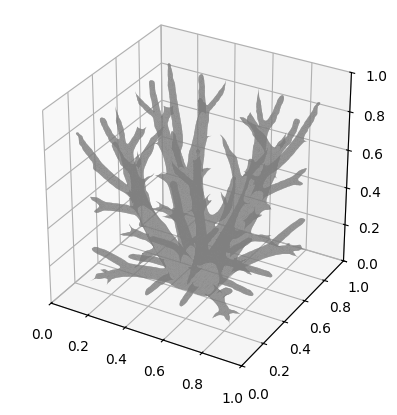

In [8]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.tri import Triangulation
import pyvista as pv
import numpy as np
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# triangulate
surf_smooth = surf.smooth_taubin(n_iter=50, non_manifold_smoothing=True).triangulate()

# Extract points
points = surf_smooth.points

# Parse the 1D faces array: [n, v1, v2, v3, n, v1, v2, v3, ...]
# TY cursor
faces_1d = surf_smooth.faces
triangles = []
i = 0
while i < len(faces_1d):
    n_verts = faces_1d[i]
    if n_verts == 3:  # Only process triangles
        verts = faces_1d[i + 1 : i + 1 + n_verts]
        triangles.append(points[verts])
    i += n_verts + 1

triangles = np.array(triangles)

# Plot with Poly3DCollection
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
collection = Poly3DCollection(
    triangles, alpha=0.7, facecolor="gray", linewidth=0.0
)
ax.add_collection3d(collection)

# Set limits
ax.set_xlim(0.0, L)
ax.set_ylim(0.0, L)
ax.set_zlim(0.0, L)
ax.set_aspect("equal")
# ax.set_axis_off();